# 03 - LSTM Model
## TCI6313 Computational Intelligence Project
### Long Short-Term Memory Network for Time-Series Air Quality Prediction

---

**Objective:** Implement LSTM to capture temporal dependencies in air quality data.

**Model Type:** LSTM (Long Short-Term Memory) Recurrent Neural Network

**CI Justification:**
- LSTMs are a specialized form of RNN (Recurrent Neural Network)
- Designed to learn long-term dependencies through gating mechanisms
- Particularly suited for time-series data where past values influence future
- Air quality follows temporal patterns (rush hours, daily cycles, seasons)

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from datetime import datetime
import time
import importlib

# Add src to path
sys.path.insert(0, os.path.abspath('../src'))

# Force reload to get latest version
import preprocessing
importlib.reload(preprocessing)

# Import custom modules
from preprocessing import prepare_data_for_lstm, prepare_data_for_lstm_univariate, inverse_transform_predictions
from lstm_model import LSTMModel, create_lstm_model, train_and_evaluate_lstm
from evaluation import (
    evaluate_model, compute_rmse, compute_mae,
    plot_actual_vs_predicted, plot_residuals, plot_training_history,
    print_evaluation_summary, save_results_to_json
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display current time
print("="*60)
print(f"🕒 Current Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)
print("Libraries and modules imported successfully!")

🕒 Current Time: 2026-01-10 20:58:30
Libraries and modules imported successfully!


## 1. Data Preprocessing for LSTM

LSTM requires sequential input data. We use sliding windows to create sequences.

### Two Approaches:

**A. Multivariate LSTM**: Uses ALL features (like ANN) but in sequence form
- Pros: Uses more information
- Cons: LSTM must learn both feature relationships AND temporal patterns

**B. Univariate LSTM (Kaggle-style)**: Uses ONLY target variable history
- Pros: Pure time-series forecasting (what LSTM excels at)
- Cons: Ignores other features

**We will use BOTH approaches and compare results for fair academic analysis.**

In [2]:
# Configuration - TWO APPROACHES FOR FAIR COMPARISON
DATA_PATH = '../data/AirQuality.csv'
TARGET_COLUMN = 'C6H6(GT)'
SEQUENCE_LENGTH = 24    # 24 hours of history
TEST_SIZE = 0.15
VAL_SIZE = 0.15

# Choose approach: 'univariate' (Kaggle-style) or 'multivariate' (traditional)
LSTM_APPROACH = 'univariate'  # Change this to compare approaches

print("="*60)
print(f"🕒 Data Loading Started: {datetime.now().strftime('%H:%M:%S')}")
print(f"📊 LSTM Approach: {LSTM_APPROACH.upper()}")
print("="*60)

start_time = time.time()

# Preprocess data based on selected approach
if LSTM_APPROACH == 'univariate':
    print("\n📌 Using UNIVARIATE approach (Kaggle-style)")
    print("   - Input: Past 24 values of C6H6 only")
    print("   - Output: Next C6H6 value")
    print("   - This is pure time-series forecasting\n")
    
    data = prepare_data_for_lstm_univariate(
        filepath=DATA_PATH,
        target_column=TARGET_COLUMN,
        sequence_length=SEQUENCE_LENGTH,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        scaler_type='minmax',  # MinMax common for univariate LSTM
        random_state=RANDOM_SEED
    )
else:
    print("\n📌 Using MULTIVARIATE approach (traditional)")
    print("   - Input: Past 24 time steps of ALL features")
    print("   - Output: Next C6H6 value")
    print("   - LSTM must learn feature relationships + temporal patterns\n")
    
    data = prepare_data_for_lstm(
        filepath=DATA_PATH,
        target_column=TARGET_COLUMN,
        sequence_length=SEQUENCE_LENGTH,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        scaler_type='standard',
        random_state=RANDOM_SEED
    )

load_time = time.time() - start_time
print(f"\n✓ Data loaded in {load_time:.2f} seconds")
print(f"🕒 Completed at: {datetime.now().strftime('%H:%M:%S')}")
print("="*60)

🕒 Data Loading Started: 20:58:43
📊 LSTM Approach: UNIVARIATE

📌 Using UNIVARIATE approach (Kaggle-style)
   - Input: Past 24 values of C6H6 only
   - Output: Next C6H6 value
   - This is pure time-series forecasting

PREPROCESSING FOR UNIVARIATE LSTM (Kaggle-style)
[INFO] Loaded dataset with shape: (9357, 15)
[INFO] Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
[INFO] Created datetime features. New shape: (9357, 23)
[INFO] Missing values before handling: 16701
[INFO] Missing values after handling: 0
[INFO] Final shape after handling missing values: (924, 23)
[INFO] Using univariate approach: only C6H6(GT)
[INFO] Total samples: 924
[INFO] Split: Train=648, Val=138, Test=138
[INFO] Sequences created:
       X_train: (624, 24, 1), y_train: (624,)
       X_val: (114, 24, 1), y_val: (114,)
       X_test: (114, 24, 1), y_test: (114,)
UNIVARIATE PREPROCESSING COM

In [3]:
# Extract data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nSequence shape: {X_train.shape}")
print(f"  - Samples: {X_train.shape[0]}")
print(f"  - Time steps: {X_train.shape[1]}")
print(f"  - Features: {X_train.shape[2]}")

Training samples: 624
Validation samples: 114
Test samples: 114

Sequence shape: (624, 24, 1)
  - Samples: 624
  - Time steps: 24
  - Features: 1


## 2. LSTM Model Architecture

### Why LSTM for Air Quality?

1. **Temporal Patterns**: Pollution levels follow daily cycles (rush hours)
2. **Long-term Dependencies**: Weather effects can persist for hours
3. **Sequential Nature**: Current air quality depends on previous hours

### Architecture Design:
For **UNIVARIATE** approach:
- Simpler architecture works better (fewer features to process)
- Focus on learning temporal patterns in single time-series

For **MULTIVARIATE** approach:
- Larger architecture needed (more feature combinations)
- Must learn both feature relationships AND temporal patterns

In [4]:
# Model Configuration - ADAPTED FOR EACH APPROACH
if LSTM_APPROACH == 'univariate':
    # Simpler model for univariate (Kaggle-style)
    MODEL_CONFIG = {
        'lstm_layers': [50, 25],    # Smaller - only 1 feature
        'dense_layers': [16],       # Small dense layer
        'learning_rate': 0.001,
        'dropout_rate': 0.2,
        'recurrent_dropout': 0.0,
        'bidirectional': False
    }
    TRAIN_CONFIG = {
        'epochs': 100,
        'batch_size': 32,
        'early_stopping_patience': 15
    }
else:
    # Larger model for multivariate
    MODEL_CONFIG = {
        'lstm_layers': [128, 64],
        'dense_layers': [32],
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'recurrent_dropout': 0.0,
        'bidirectional': False
    }
    TRAIN_CONFIG = {
        'epochs': 150,
        'batch_size': 32,
        'early_stopping_patience': 25
    }

print("="*60)
print(f"⚙️  MODEL CONFIGURATION ({LSTM_APPROACH.upper()} APPROACH)")
print("="*60)
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {v}")
print("\n🏃 TRAINING CONFIGURATION")
print("-"*60)
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")
print("="*60)
print(f"\n📊 Input shape: {data['X_train'].shape}")
print(f"   - Samples: {data['X_train'].shape[0]}")
print(f"   - Time steps: {data['X_train'].shape[1]}")
print(f"   - Features: {data['X_train'].shape[2]}")
print("="*60)

⚙️  MODEL CONFIGURATION (UNIVARIATE APPROACH)
  lstm_layers: [50, 25]
  dense_layers: [16]
  learning_rate: 0.001
  dropout_rate: 0.2
  recurrent_dropout: 0.0
  bidirectional: False

🏃 TRAINING CONFIGURATION
------------------------------------------------------------
  epochs: 100
  batch_size: 32
  early_stopping_patience: 15

📊 Input shape: (624, 24, 1)
   - Samples: 624
   - Time steps: 24
   - Features: 1


In [5]:
# Create LSTM Model
lstm_model = LSTMModel(
    sequence_length=SEQUENCE_LENGTH,
    n_features=data['n_features'],
    lstm_layers=MODEL_CONFIG['lstm_layers'],
    dense_layers=MODEL_CONFIG['dense_layers'],
    learning_rate=MODEL_CONFIG['learning_rate'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    recurrent_dropout=MODEL_CONFIG['recurrent_dropout'],
    bidirectional=MODEL_CONFIG['bidirectional'],
    random_seed=RANDOM_SEED
)

# Build the model
lstm_model.build()

[INFO] Building LSTM model...

LSTM MODEL ARCHITECTURE


Model: "LSTM_TimeSeries"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,465 (72.13 KB)

 Non-trainable params: 32 (128.00 B)

## 3. Model Training

In [6]:
# Train the model
print("="*60)
print("🚀 TRAINING STARTED")
print("="*60)
print(f"🕒 Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Training samples: {X_train.shape[0]}")
print(f"📊 Validation samples: {X_val.shape[0]}")
print(f"⚙️  Epochs: {TRAIN_CONFIG['epochs']}")
print(f"⚙️  Batch size: {TRAIN_CONFIG['batch_size']}")
print(f"⚙️  Batches per epoch: {X_train.shape[0] // TRAIN_CONFIG['batch_size']}")
print("="*60)

# Estimate training time
samples = X_train.shape[0]
batches_per_epoch = samples // TRAIN_CONFIG['batch_size']
total_batches = batches_per_epoch * TRAIN_CONFIG['epochs']
print(f"\n💡 Estimated time (CPU): ~{total_batches * 0.3 / 60:.1f}-{total_batches * 0.5 / 60:.1f} minutes")
print("   (Each batch ~0.3-0.5 seconds on typical CPU)")
print("\n⏳ Training in progress... (watch the progress bar below)")
print("="*60)
print()

training_start = time.time()

history = lstm_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=TRAIN_CONFIG['epochs'],
    batch_size=TRAIN_CONFIG['batch_size'],
    early_stopping_patience=TRAIN_CONFIG['early_stopping_patience'],
    verbose=1  # Shows progress bar
)

training_time = time.time() - training_start

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"🕒 End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"⚡ Avg time per epoch: {training_time/len(history['loss']):.2f} seconds")
print("="*60)


🚀 TRAINING STARTED
🕒 Start Time: 2026-01-10 20:59:10
📊 Training samples: 624
📊 Validation samples: 114
⚙️  Epochs: 100
⚙️  Batch size: 32
⚙️  Batches per epoch: 19

💡 Estimated time (CPU): ~9.5-15.8 minutes
   (Each batch ~0.3-0.5 seconds on typical CPU)

⏳ Training in progress... (watch the progress bar below)

[INFO] Starting LSTM training...
       Epochs: 100, Batch size: 32
       Sequence length: 24
       Training samples: 624
       Validation samples: 114
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.1775 - mae: 0.2833 - val_loss: 0.0981 - val_mae: 0.2336 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0538 - mae: 0.1513 - val_loss: 0.0713 - val_mae: 0.1958 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0446 - mae: 0.1399 - val_loss: 0.0615 - val_mae: 0.1820 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0407 - mae: 0.1394 - val_loss: 0.0596 - val

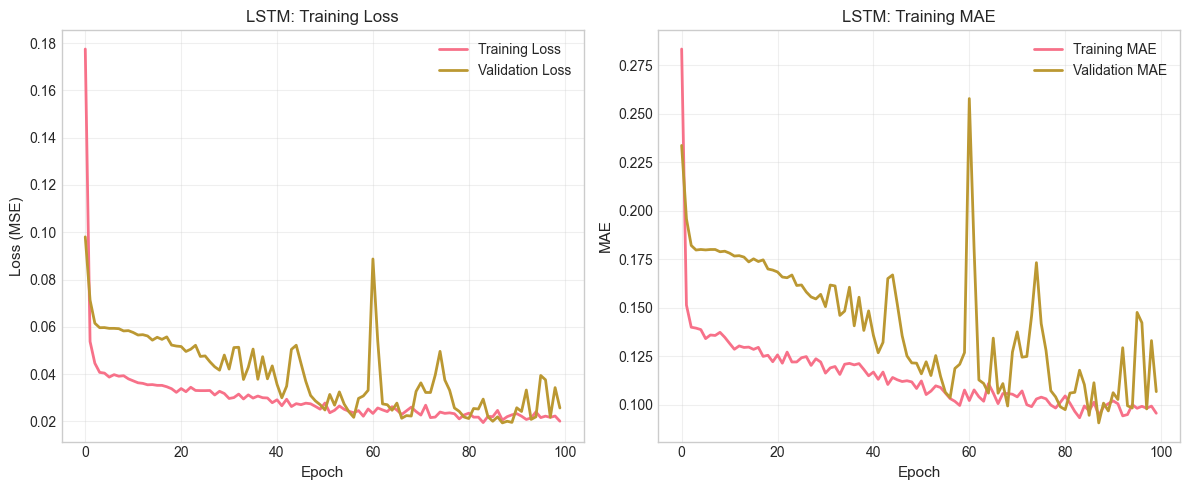

In [7]:
# Plot training history
fig = plot_training_history(history, model_name='LSTM')
plt.show()

## 4. Model Evaluation

In [8]:
# Make predictions
y_pred_train = lstm_model.predict(X_train)
y_pred_val = lstm_model.predict(X_val)
y_pred_test = lstm_model.predict(X_test)

# Inverse transform to original scale
y_train_orig = inverse_transform_predictions(y_train, data['target_scaler'])
y_val_orig = inverse_transform_predictions(y_val, data['target_scaler'])
y_test_orig = inverse_transform_predictions(y_test, data['target_scaler'])

y_pred_train_orig = inverse_transform_predictions(y_pred_train, data['target_scaler'])
y_pred_val_orig = inverse_transform_predictions(y_pred_val, data['target_scaler'])
y_pred_test_orig = inverse_transform_predictions(y_pred_test, data['target_scaler'])

In [9]:
# Evaluate on all sets
print("="*60)
print("LSTM MODEL EVALUATION RESULTS")
print("="*60)

# Training set
train_metrics = evaluate_model(y_train_orig, y_pred_train_orig, 'LSTM-Train')
print(f"\nTraining Set:")
print(f"  RMSE: {train_metrics['rmse']:.4f}")
print(f"  MAE:  {train_metrics['mae']:.4f}")
print(f"  R²:   {train_metrics['r2']:.4f}")

# Validation set
val_metrics = evaluate_model(y_val_orig, y_pred_val_orig, 'LSTM-Val')
print(f"\nValidation Set:")
print(f"  RMSE: {val_metrics['rmse']:.4f}")
print(f"  MAE:  {val_metrics['mae']:.4f}")
print(f"  R²:   {val_metrics['r2']:.4f}")

# Test set
test_metrics = evaluate_model(y_test_orig, y_pred_test_orig, 'LSTM-Test',
                               training_time=lstm_model.training_time)
print(f"\nTest Set:")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  R²:   {test_metrics['r2']:.4f}")

print(f"\nTraining Time: {lstm_model.training_time:.2f} seconds")
print("="*60)

LSTM MODEL EVALUATION RESULTS

Training Set:
  RMSE: 4.1797
  MAE:  3.0394
  R²:   0.6491

Validation Set:
  RMSE: 4.8838
  MAE:  3.5039
  R²:   0.6333

Test Set:
  RMSE: 4.8651
  MAE:  3.4806
  R²:   0.6240

Training Time: 70.96 seconds


## 5. Visualizations

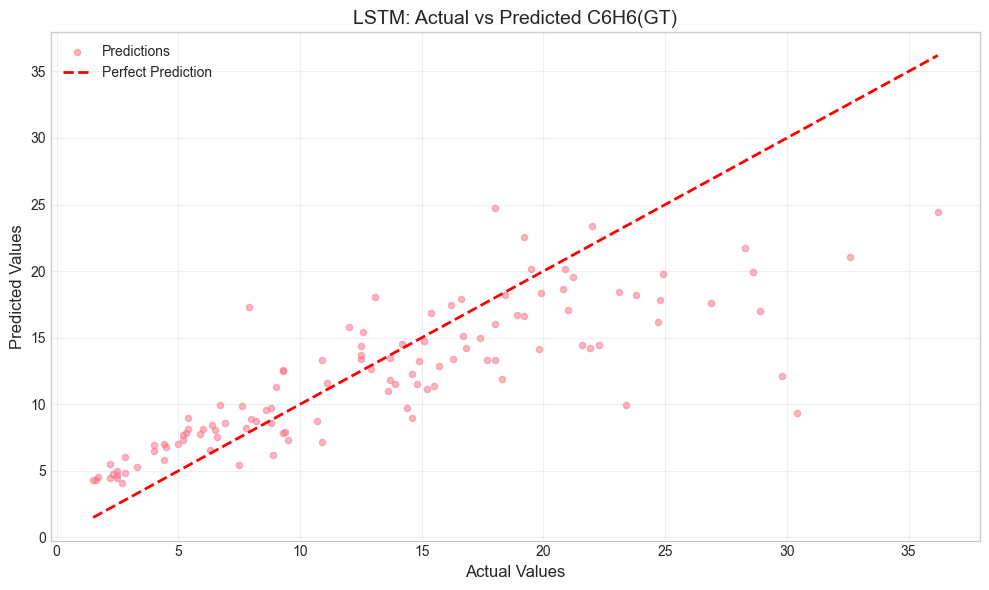

In [10]:
# Actual vs Predicted plot
fig = plot_actual_vs_predicted(
    y_test_orig, y_pred_test_orig,
    model_name='LSTM',
    title=f'LSTM: Actual vs Predicted {TARGET_COLUMN}'
)
plt.show()

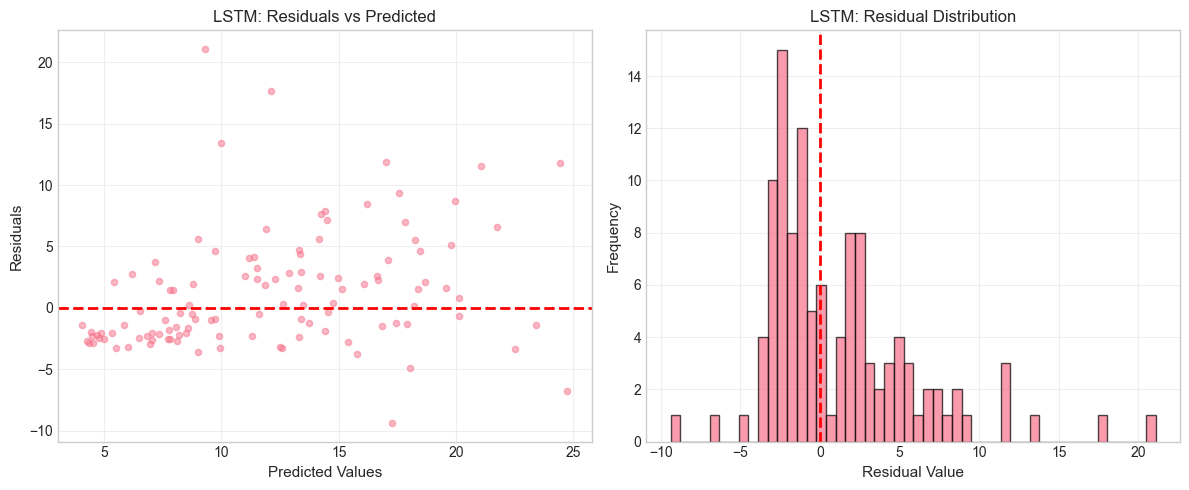

In [11]:
# Residual analysis
fig = plot_residuals(y_test_orig, y_pred_test_orig, model_name='LSTM')
plt.show()

Plotting last 114 test samples (total test samples: 114)


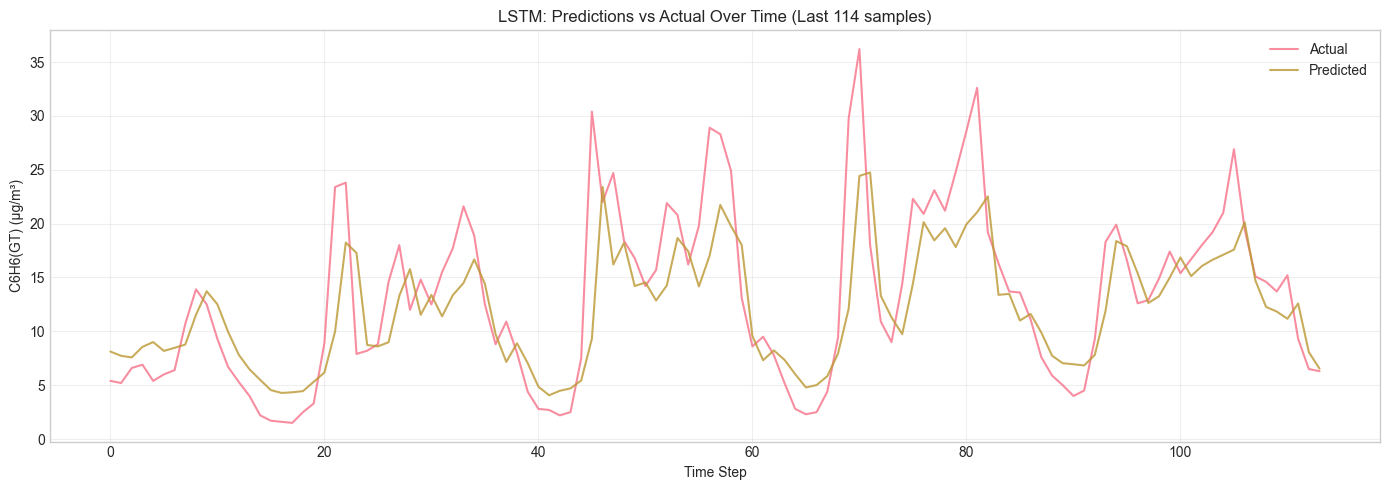

In [12]:
# Predictions over time (fixed to handle small test sets)
n_points = min(200, len(y_test_orig))  # Don't exceed available data

print(f"Plotting last {n_points} test samples (total test samples: {len(y_test_orig)})")

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_points), y_test_orig[-n_points:], label='Actual', alpha=0.8, lw=1.5)
ax.plot(range(n_points), y_pred_test_orig[-n_points:], label='Predicted', alpha=0.8, lw=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'{TARGET_COLUMN} (µg/m³)')
ax.set_title(f'LSTM: Predictions vs Actual Over Time (Last {n_points} samples)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Save Results

In [13]:
# Compile results
lstm_results = {
    'model_type': 'LSTM',
    'approach': LSTM_APPROACH,
    'model_config': MODEL_CONFIG,
    'train_config': TRAIN_CONFIG,
    'sequence_length': SEQUENCE_LENGTH,
    'n_features': data['n_features'],
    'metrics': {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    },
    'training_time': lstm_model.training_time,
    'history': history,
    'predictions': {
        'test_actual': y_test_orig.tolist(),
        'test_predicted': y_pred_test_orig.tolist()
    }
}

# Save to JSON (with approach in filename)
results_filename = f'../results/lstm_{LSTM_APPROACH}_results.json'
save_results_to_json(lstm_results, results_filename)

print(f"Results saved to {results_filename}!")

[INFO] Results saved to ../results/lstm_univariate_results.json
Results saved to ../results/lstm_univariate_results.json!
